# MNISTでセグメンテーションに挑戦



In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import binarybrain as bb

## 初期設定

In [2]:
# configuration
net_name              = 'MnistSegmentation'
data_path             = os.path.join('./data/', net_name)
rtl_sim_path          = '../../verilog/mnist'
rtl_module_name       = 'MnistSegmentation'
output_velilog_file   = os.path.join(data_path, rtl_module_name + '.v')
sim_velilog_file      = os.path.join(rtl_sim_path, rtl_module_name + '.v')

bin_mode              = True
frame_modulation_size = 1
epochs                = 32
mini_batch_size       = 32

rows = 4
cols = 4
depth = 28

## データセット準備

データセットを自作する

In [3]:
# dataset
dataset_path = './data/'
dataset_train = torchvision.datasets.MNIST(root=dataset_path, train=True, transform=transforms.ToTensor(), download=True)
dataset_test  = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transforms.ToTensor(), download=True)

# 面積の比率で重みを作っておく
areas = np.zeros((11))
for img, label in dataset_train:
    img = img.numpy()
    areas[label] += np.mean(img)
    areas[10] += np.mean(1.0-img)
areas /= len(dataset_train)

wight = 1 / areas
wight /= np.max(wight)

def make_teacher_image(gen, rows, cols, margin=0):
    source_img  = np.zeros((1, rows*28, cols*28), dtype=np.float32)
    teaching_img = np.zeros((11, rows*28, cols*28), dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            x = col*28
            y = row*28
            img, label = gen.__next__()
            source_img[0,y:y+28,x:x+28] = img
            teaching_img[label,y:y+28,x:x+28] = img
            teaching_img[10,y:y+28,x:x+28] = 1.0-img
    for i in range(11):
        teaching_img[i] *= wight[i]
    return source_img, teaching_img[:,margin:-margin,margin:-margin]

def transform_data(dataset, n, rows, cols, margin):
    def data_gen():
        l = len(dataset)
        i = 0
        while True:
            yield dataset[i%l]
            i +=1
    
    gen = data_gen()
    source_imgs = []
    teaching_imgs = []
    for _ in range(n):
        x, t = make_teacher_image(gen, rows, cols, margin)
        source_imgs.append(x)
        teaching_imgs.append(t)
    return source_imgs, teaching_imgs

class MyDatasets(torch.utils.data.Dataset):
    def __init__(self, source_imgs, teaching_imgs, transforms=None):
        self.transforms = transforms
        self.source_imgs = source_imgs
        self.teaching_imgs = teaching_imgs
        
    def __len__(self):
        return len(self.source_imgs)

    def __getitem__(self, index):
        source_img = self.source_imgs[index]
        teaching_img = self.teaching_imgs[index]
        if self.transforms:
            source_img, teaching_img = self.transforms(source_img, teaching_img)
        return source_img, teaching_img


source_imgs_train, teaching_imgs_train = transform_data(dataset_train, mini_batch_size*50, rows, cols, depth)
my_dataset_train = MyDatasets(source_imgs_train, teaching_imgs_train)

source_imgs_test, teaching_imgs_test = transform_data(dataset_test, mini_batch_size*5, rows, cols, depth)
my_dataset_test = MyDatasets(source_imgs_test, teaching_imgs_test)

loader_train = torch.utils.data.DataLoader(dataset=my_dataset_train, batch_size=mini_batch_size, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset=my_dataset_test, batch_size=mini_batch_size, shuffle=False)

torch.Size([1, 112, 112])
torch.Size([11, 56, 56])


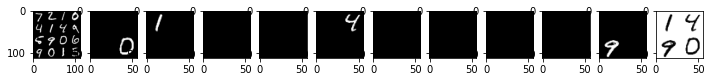

torch.Size([1, 112, 112])
torch.Size([11, 56, 56])


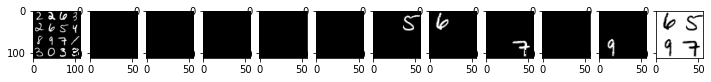

torch.Size([1, 112, 112])
torch.Size([11, 56, 56])


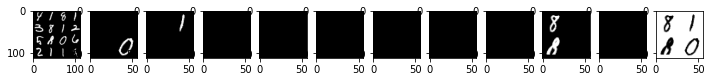

torch.Size([1, 112, 112])
torch.Size([11, 56, 56])


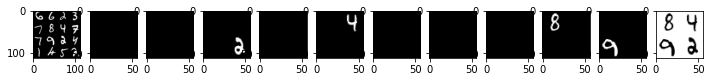

torch.Size([1, 112, 112])
torch.Size([11, 56, 56])


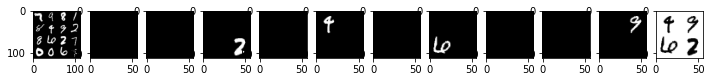

In [4]:
i = 0
for source_imgs, teaching_imgs in loader_test:
    print(source_imgs[0].shape)
    print(teaching_imgs[0].shape)
    plt.figure(figsize=(12,6))
    plt.subplot(1,12,1)
    plt.imshow(source_imgs[0][0], 'gray')
    for j in range(11):
        plt.subplot(1,12,2+j)
        plt.imshow(teaching_imgs[0][j], 'gray')
    plt.show()
    i += 1
    if i > 5:
        break

## ネットワーク構築

In [5]:
class BinaryResLayer(bb.Model):
    pass

In [6]:
a = 'abc'*2
print(a)

abcabc


In [7]:
# バイナリ時は BIT型を使えばメモリ削減可能
bin_dtype = bb.DType.BIT if bin_mode else bb.DType.FP32

def make_conv_layer(hidden_ch, output_ch, padding='valid', bin_dtype=bb.DType.BIT):
    return bb.Sequential([
                # input(pointwise)
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([hidden_ch*6, 1, 1], bin_dtype=bin_dtype),
                        bb.DifferentiableLut([hidden_ch,   1, 1], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(1, 1),
                    fw_dtype=bin_dtype),

                # hidden(depthwise)
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([hidden_ch, 1, 1], connection='depthwise', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(3, 3), padding=padding,
                    fw_dtype=bin_dtype),
                
                # output(pointwise)
                bb.Convolution2d(
                    bb.Sequential([
                        bb.DifferentiableLut([output_ch*6, 1, 1], connection='serial', bin_dtype=bin_dtype),
                        bb.DifferentiableLut([output_ch,   1, 1], connection='serial', bin_dtype=bin_dtype),
                    ]),
                    filter_size=(1, 1),
                    fw_dtype=bin_dtype),
            ])


sub_net = bb.Sequential()

for i in range(depth-1):
    sub_net.append(make_conv_layer(72, 36, bin_dtype=bin_dtype))

sub_net.append(
            bb.Convolution2d(
                bb.Sequential([
                    bb.DifferentiableLut([512],    connection='serial', batch_norm=True, bin_dtype=bin_dtype),
                    bb.DifferentiableLut([11*6*6], connection='random', batch_norm=False, bin_dtype=bin_dtype),
                    bb.DifferentiableLut([11*6],   connection='serial', batch_norm=False, bin_dtype=bin_dtype),
                    bb.DifferentiableLut([11],     connection='serial', batch_norm=False, bin_dtype=bin_dtype),
                ]),
                filter_size=(3, 3),
                fw_dtype=bin_dtype))
    
# define network
net = bb.Sequential([
            bb.RealToBinary(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype),
            sub_net,
            bb.BinaryToReal(frame_modulation_size=frame_modulation_size, bin_dtype=bin_dtype)
        ])

net.set_input_shape([1, 4*28, 4*28])

if bin_mode:
    net.send_command("binary true")

print(net.get_info(2))

  --------------------------------------------------------------------
  [RealToBinary] 
   input  shape : {1, 112, 112}   output shape : {1, 112, 112}
  --------------------------------------------------------------------
  [Sequential] 
   input  shape : {1, 112, 112}   output shape : {36, 58, 58}
  --------------------------------------------------------------------
  [BinaryToReal] 
   input  shape : {11, 56, 56}   output shape : {11, 56, 56}



In [8]:
bb.load_networks(data_path, net)

load : ./data/MnistSegmentation\20210103_155836


## 学習実施

学習を行います

In [9]:
# 重み付きの損失関数を自作する
class MyLoss(bb.LossFunction):
    def __init__(self, weight):
        super(MyLoss, self).__init__(self)
        self.weight = weight
        self.clear()
        
    def clear(self):
        self.loss = 0.
        self.n    = 0
        
    def get(self):
        if self.n == 0:
            return 0
        return self.loss / self.n
                
    def calculate(self, y_buf, t_buf):
        grad = y_buf.numpy() - t_buf.numpy();
        grad *= self.weight
        err  = grad * grad
        self.loss += np.mean(err) * y_buf.get_frame_size()
        self.n += y_buf.get_frame_size()
        return bb.FrameBuffer.from_numpy(grad)

load : ./data/MnistSegmentation\20210103_155836


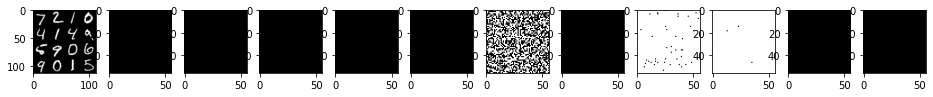

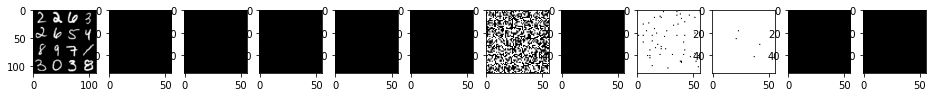

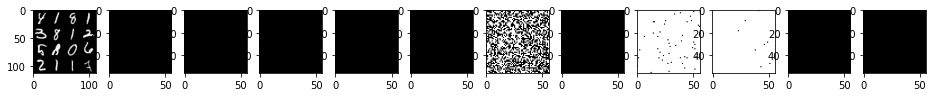

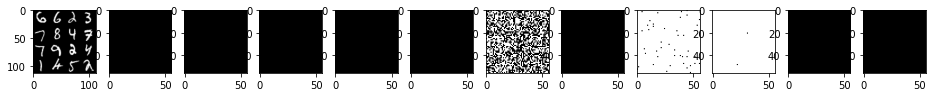

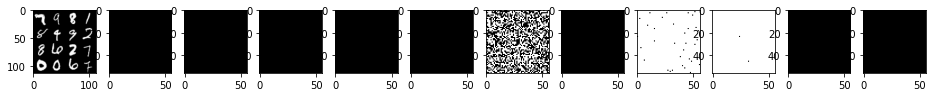

In [ ]:
bb.load_networks(data_path, net)

# learning
loss      = bb.LossSoftmaxCrossEntropy() # MyLoss(loss_weight) # bb.LossMeanSquaredError()
metrics   = bb.MetricsCategoricalAccuracy()
optimizer = bb.OptimizerAdam()

optimizer.set_variables(net.get_parameters(), net.get_gradients())

for epoch in range(epochs):
    # View
    i = 0
    for x_imgs, t_imgs in loader_test:
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
        t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
        y_buf = net.forward(x_buf, train=False)
        result_imgs = y_buf.numpy()
        
        plt.figure(figsize=(16,8))
        plt.subplot(1,12,1)
        plt.imshow(x_imgs[0][0], 'gray')
        for j in range(11):
            plt.subplot(1,12,2+j)
            plt.imshow(result_imgs[0][j], 'gray')
        plt.show()
        
        i += 1
        if i > 5:
            break
    
    # learning
    loss.clear()
    metrics.clear()
    with tqdm(loader_train) as tqdm_loadr:
        for x_imgs, t_imgs in tqdm_loadr:
            x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
            t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
            
            y_buf = net.forward(x_buf, train=True)

            dy_buf = loss.calculate(y_buf, t_buf)
            metrics.calculate(y_buf, t_buf)
            
            net.backward(dy_buf)

            optimizer.update()

            tqdm_loadr.set_postfix(loss=loss.get(), acc=metrics.get())
    
    # test
    loss.clear()
    metrics.clear()
    for x_imgs, t_imgs in loader_test:
        x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
        t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))

        y_buf = net.forward(x_buf, train=False)

        loss.calculate(y_buf, t_buf)
        metrics.calculate(y_buf, t_buf)

    bb.save_networks(data_path, net)

    print('epoch[%d] : loss=%f acc=%f' % (epoch, loss.get(), metrics.get()))

In [ ]:
plt.figure(figsize=(16,8))
for source_imgs, teaching_imgs in loader_test:
    x_buf = bb.FrameBuffer.from_numpy(np.array(x_imgs).astype(np.float32))
    t_buf = bb.FrameBuffer.from_numpy(np.array(t_imgs).astype(np.float32))
    y_buf = net.forward(x_buf, train=False)
    result_imgs = y_buf.numpy()
        
    plt.subplot(1,12,1)
    plt.imshow(source_imgs[0][0], 'gray')
    for i in range(11):
        plt.subplot(1,12,2+i)
        plt.imshow(result_imgs[0][i], 'gray')
    break

## RTL(Verilog)変換

FPGA化するために Verilog に変換します。インターフェースはXilinx社のAXI4 Stream Video 仕様(フレームスタートでtuserが立つ)となります。
MaxPooling の単位で画像サイズが縮小されてしまうので、現状、この単位でしか変換できないため3つに分けて出力しています。

In [ ]:
# export verilog
with open(output_velilog_file, 'w') as f:
    f.write('`timescale 1ns / 1ps\n\n')
    bb.dump_verilog_lut_cnv_layers(f, rtl_module_name, sub_net)

# Simulation用ファイルに上書きコピー
shutil.copyfile(output_velilog_file, sim_velilog_file)